In [1]:
import keras
import sklearn
import pandas as pd
import numpy as np

from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from math import sqrt

Using TensorFlow backend.


In [2]:
from tqdm import tqdm_notebook

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Embedding, Activation, Dropout, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

In [3]:
all_data = pd.read_csv(r'training_set_rel3.tsv',sep='\t', encoding='latin1')

In [4]:
SentenceEnders=r'!.?'
SentenceContinuation=r',:;-'

def EssayLength(Essay):
    return len(Essay.split())

def CountSentences(Essay):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(Essay, set(SentenceEnders))

def CountContinuation(Essay):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(Essay, set(SentenceContinuation))

In [5]:
classification_data = all_data
DivSeries = pd.DataFrame({'div': [12,5,3,3,4,4,25,50],'dataset':[1,2,3,4,5,6,7,8]})

# score normalization
for i in all_data.essay_set.unique():
    if(i==1):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 12
    elif (i==2):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 5
    elif (i in (3,4)):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 3
    elif (i in (5,6)):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 4
    elif (i == 7):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 25
    else:
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 50


train_sa_x_class,test_sa_x_class,train_sa_y_class,test_sa_y_class = train_test_split(np.asarray(classification_data.essay), classification_data[['adjusted_domain1_score','essay_set']],test_size=0.2, random_state=42)

max_len_class = all_data.essay.apply(EssayLength).sort_values(ascending=True).iloc[int(np.floor(len(all_data)*.95))]

tok_class = Tokenizer()
tok_class.fit_on_texts(pd.Series(train_sa_x_class))
sequences_class = tok_class.texts_to_sequences(train_sa_x_class)
sequences_matrix_class = sequence.pad_sequences(sequences_class,maxlen=max_len_class)

sequences_test_class = tok_class.texts_to_sequences(test_sa_x_class)
sequences_test_matrix_class = sequence.pad_sequences(sequences_test_class,maxlen=max_len_class)

In [ ]:
classification_data = all_data
DivSeries = pd.DataFrame({'div': [12,5,3,3,4,4,25,50],'dataset':[1,2,3,4,5,6,7,8]})

# score normalization
for i in all_data.essay_set.unique():
    if(i==1):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 12
    elif (i==2):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 5
    elif (i in (3,4)):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 3
    elif (i in (5,6)):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 4
    elif (i == 7):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 25
    else:
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 50


train_sa_x_class,test_sa_x_class,train_sa_y_class,test_sa_y_class = train_test_split(np.asarray(classification_data.essay), classification_data[['adjusted_domain1_score','essay_set']],test_size=0.2, random_state=42)

max_len_class = all_data.essay.apply(EssayLength).sort_values(ascending=True).iloc[int(np.floor(len(all_data)*.95))]

tok_class = Tokenizer()
tok_class.fit_on_texts(pd.Series(train_sa_x_class))
sequences_class = tok_class.texts_to_sequences(train_sa_x_class)
sequences_matrix_class = sequence.pad_sequences(sequences_class,maxlen=max_len_class)

sequences_test_class = tok_class.texts_to_sequences(test_sa_x_class)
sequences_test_matrix_class = sequence.pad_sequences(sequences_test_class,maxlen=max_len_class)

In [6]:
#looking to pull glove embeddings so no embedding training required.
import csv
gloves = pd.read_table(r"glove.42B.300d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((len(tok_class.word_index)+1, 300))
for word, i in tqdm_notebook(tok_class.word_index.items()):
    if word in gloves.index:
        embedding_matrix[i] = np.asarray(gloves.loc[word])
    else:
        embedding_matrix[i] = np.zeros(300)

# Feed-forward networks:

In [50]:
ff_1 = Sequential()
ff_1.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
ff_1.add(Dense(100,name='deep1'))
ff_1.add(Flatten())
#Regression
# ff_1.add(Dense(1,activation='sigmoid',name='out_layer'))
# ff_1.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
# ff_1.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#Classification
ff_1.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),activation='sigmoid',name='out_layer'))
ff_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
ff_1.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 11s 1ms/step - loss: 2.8057 - acc: 0.1944 - val_loss: 2.4925 - val_acc: 0.1908
Epoch 2/35
8823/8823 [==============================] - 8s 957us/step - loss: 2.1753 - acc: 0.2095 - val_loss: 2.3643 - val_acc: 0.2338
Epoch 3/35
8823/8823 [==============================] - 8s 962us/step - loss: 1.6923 - acc: 0.3398 - val_loss: 2.1719 - val_acc: 0.3571
Epoch 4/35
8823/8823 [==============================] - 9s 983us/step - loss: 0.9683 - acc: 0.6758 - val_loss: 2.0156 - val_acc: 0.4586
Epoch 5/35
8823/8823 [==============================] - 9s 987us/step - loss: 0.4367 - acc: 0.8649 - val_loss: 2.0072 - val_acc: 0.4798
Epoch 6/35
8823/8823 [==============================] - 9s 972us/step - loss: 0.2051 - acc: 0.9512 - val_loss: 2.0725 - val_acc: 0.4920
Epoch 7/35
8823/8823 [==============================] - 9s 974us/step - loss: 0.1221 - acc: 0.9833 - val_loss: 2.2077 - val_acc: 0.4862
E

In [51]:
ff_2 = Sequential()
ff_2.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
ff_2.add(Dense(100,name='deep1'))
ff_2.add(Dense(50,name='deep2'))
ff_2.add(Flatten())
#Regression
# ff_2.add(Dense(1,activation='sigmoid',name='out_layer'))
# ff_2.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
# ff_2.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#Classification
ff_2.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),activation='sigmoid',name='out_layer'))
ff_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
ff_2.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 12s 1ms/step - loss: 2.7084 - acc: 0.1779 - val_loss: 2.3053 - val_acc: 0.2171
Epoch 2/35
8823/8823 [==============================] - 10s 1ms/step - loss: 1.9089 - acc: 0.2373 - val_loss: 2.1948 - val_acc: 0.2563
Epoch 3/35
8823/8823 [==============================] - 10s 1ms/step - loss: 1.3949 - acc: 0.4735 - val_loss: 2.0170 - val_acc: 0.4200
Epoch 4/35
8823/8823 [==============================] - 10s 1ms/step - loss: 0.7450 - acc: 0.7462 - val_loss: 1.9146 - val_acc: 0.4701
Epoch 5/35
8823/8823 [==============================] - 10s 1ms/step - loss: 0.4104 - acc: 0.8646 - val_loss: 2.0374 - val_acc: 0.4611
Epoch 6/35
8823/8823 [==============================] - 10s 1ms/step - loss: 0.2568 - acc: 0.9250 - val_loss: 2.2464 - val_acc: 0.4554
Epoch 7/35
8823/8823 [==============================] - 10s 1ms/step - loss: 0.1774 - acc: 0.9583 - val_loss: 2.3598 - val_acc: 0.4637
Epoch 8

In [52]:
ff_3 = Sequential()
ff_3.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
ff_3.add(Dense(100,name='deep1'))
ff_3.add(Dense(50,name='deep2'))
ff_3.add(Dense(25,name='deep3'))
ff_3.add(Flatten())
#Regression
# ff_3.add(Dense(1,activation='sigmoid',name='out_layer'))
# ff_3.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
# ff_3.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#Classification
ff_3.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),activation='sigmoid',name='out_layer'))
ff_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
ff_3.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 14s 2ms/step - loss: 2.7220 - acc: 0.1944 - val_loss: 2.3549 - val_acc: 0.2017
Epoch 2/35
8823/8823 [==============================] - 11s 1ms/step - loss: 2.0527 - acc: 0.2339 - val_loss: 2.1401 - val_acc: 0.2428
Epoch 3/35
8823/8823 [==============================] - 11s 1ms/step - loss: 1.6547 - acc: 0.3376 - val_loss: 2.1438 - val_acc: 0.3365
Epoch 4/35
8823/8823 [==============================] - 11s 1ms/step - loss: 1.1305 - acc: 0.5826 - val_loss: 1.9307 - val_acc: 0.4496
Epoch 5/35
8823/8823 [==============================] - 11s 1ms/step - loss: 0.6820 - acc: 0.7537 - val_loss: 2.0448 - val_acc: 0.4297
Epoch 6/35
8823/8823 [==============================] - 11s 1ms/step - loss: 0.4409 - acc: 0.8480 - val_loss: 2.4225 - val_acc: 0.4541
Epoch 7/35
8823/8823 [==============================] - 11s 1ms/step - loss: 0.3022 - acc: 0.9030 - val_loss: 2.5805 - val_acc: 0.4522
Epoch 8

In [53]:
#classification only
#required to convert from cat_CE output back to single prediction
NormalizeSeries = pd.Series(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns)
def RetrieveNormalize(IndexVal):
    return NormalizeSeries.loc[IndexVal]

In [89]:
ff_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 588, 300)          10930500  
_________________________________________________________________
deep1 (Dense)                (None, 588, 100)          30100     
_________________________________________________________________
deep2 (Dense)                (None, 588, 50)           5050      
_________________________________________________________________
deep3 (Dense)                (None, 588, 25)           1275      
_________________________________________________________________
flatten_8 (Flatten)          (None, 14700)             0         
_________________________________________________________________
out_layer (Dense)            (None, 51)                749751    
Total params: 11,716,676
Trainable params: 786,176
Non-trainable params: 10,930,500
__________________________________________________________

In [74]:
#Classification
scoringFrame_FF = pd.DataFrame(columns=['actual','dataset','feedforward','ff1','ff2', 'ff3'],index=range(0,len(test_sa_y_class)))
for i in tqdm_notebook(scoringFrame_FF.index):
    scoringFrame_FF.loc[i, 'actual'] = test_sa_y_class.adjusted_domain1_score.iloc[i]
    scoringFrame_FF.loc[i, 'dataset'] = test_sa_y_class.essay_set.iloc[i]
scoringFrame_FF.dataset = scoringFrame_FF.dataset.astype(int)

ff_pred1 = ff_1.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))#.flatten()
ff_pred2 = ff_2.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))#.flatten()
ff_pred3 = ff_3.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))#.flatten()

scoringFrame_FF['ff1'] = np.argmax(ff_pred1,axis=1)
scoringFrame_FF['ff2'] = np.argmax(ff_pred2,axis=1)
scoringFrame_FF['ff3'] = np.argmax(ff_pred3,axis=1)

#NOTE - this way of scoring is much slower than the batch scoring done for CNN/RNN. Including it for completion's sake
#regression
# scoringFrame_FF = pd.DataFrame(columns=['actual','dataset','feedforward','ff1','ff2', 'ff3'],index=range(0,len(test_sa_y_class)))
# for i in tqdm_notebook(scoringFrame_FF.index):
#     scoringFrame_FF.loc[i, 'actual'] = test_sa_y_class.adjusted_domain1_score.iloc[i]
#     scoringFrame_FF.loc[i, 'dataset'] = test_sa_y_class.essay_set.iloc[i]
#     scoringFrame_FF.loc[i, 'ff1'] = ff_1.predict(sequences_test_matrix_class[i].reshape(1,max_len_class))[0][0]
#     scoringFrame_FF.loc[i, 'ff2'] = ff_2.predict(sequences_test_matrix_class[i].reshape(1,max_len_class))[0][0]
#     scoringFrame_FF.loc[i, 'ff3'] = ff_3.predict(sequences_test_matrix_class[i].reshape(1,max_len_class))[0][0]
# scoringFrame_FF.dataset = scoringFrame_FF.dataset.astype(int)

# scoringFrame_FF = scoringFrame_FF.merge(DivSeries, on='dataset')

scoringFrame_FF = scoringFrame_FF.merge(DivSeries, on='dataset')

for colName in ['actual','ff1','ff2','ff3']:
    #classification only
    if(colName != 'actual'):
        scoringFrame_FF[colName] = scoringFrame_FF[colName].apply(RetrieveNormalize)
    scoringFrame_FF[colName] = scoringFrame_FF[colName] * scoringFrame_FF['div']
    scoringFrame_FF[colName] = scoringFrame_FF[colName].apply(round)

scoringFrame_FF.actual = scoringFrame_FF.actual.astype(int)

QuadKappaCalculation = pd.DataFrame(columns = ['ff1', 'ff2', 'ff3'],index = np.unique(scoringFrame_FF.dataset))
for essaySetValue in np.unique(scoringFrame_FF.dataset):
    temp_ff_ES = scoringFrame_FF[scoringFrame_FF.dataset == essaySetValue]
    QuadKappaCalculation.loc[essaySetValue, 'ff1'] = cohen_kappa_score(temp_ff_ES.actual, temp_ff_ES.ff1.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'ff2'] = cohen_kappa_score(temp_ff_ES.actual, temp_ff_ES.ff2.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'ff3'] = cohen_kappa_score(temp_ff_ES.actual, temp_ff_ES.ff3.apply(round),weights='quadratic')
print("Mean Weighted Quadrating Kappa scores: ")
print(QuadKappaCalculation.mean())


Mean Weighted Quadrating Kappa scores: 
ff1    0.595457
ff2    0.596776
ff3    0.543137
dtype: float64


In [308]:
print("ff1 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(scoringFrame_FF.actual, scoringFrame_FF.ff1.apply(round))),
                                       cohen_kappa_score(scoringFrame_FF.actual, scoringFrame_FF.ff1.apply(round)),
                                        cohen_kappa_score(scoringFrame_FF.actual, scoringFrame_FF.ff1.apply(round),weights='quadratic'),
                                                 accuracy_score(scoringFrame_FF.actual, scoringFrame_FF.ff1.apply(round))))

print("ff2 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(scoringFrame_FF.actual, scoringFrame_FF.ff2.apply(round))),
                                       cohen_kappa_score(scoringFrame_FF.actual, scoringFrame_FF.ff2.apply(round)),
                                        cohen_kappa_score(scoringFrame_FF.actual, scoringFrame_FF.ff2.apply(round),weights='quadratic'),             
                                      accuracy_score(scoringFrame_FF.actual, scoringFrame_FF.ff2.apply(round))))

print("ff3 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(scoringFrame_FF.actual, scoringFrame_FF.ff3.apply(round))),
                                       cohen_kappa_score(scoringFrame_FF.actual, scoringFrame_FF.ff3.apply(round)),
                                       cohen_kappa_score(scoringFrame_FF.actual, scoringFrame_FF.ff3.apply(round),weights='quadratic'),               
                                      accuracy_score(scoringFrame_FF.actual, scoringFrame_FF.ff3.apply(round))))


ff1 RMSE, Cohen, Quad Cohen, accuracy: 2.2775449707943762, 0.42612668433682255, 0.9680540716672278, 0.49768875192604006
ff2 RMSE, Cohen, Quad Cohen, accuracy: 2.399280837294699, 0.41132930150606306, 0.9632877332798625, 0.48382126348228044
ff3 RMSE, Cohen, Quad Cohen, accuracy: 2.4943696227905265, 0.3581157175355486, 0.9612553378657894, 0.43682588597842836


# Convolutional Architectures

In [104]:
cnn_1 = Sequential()
cnn_1.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
cnn_1.add(Conv1D(64, 5, activation='relu'))
cnn_1.add(MaxPooling1D(pool_size=4))
cnn_1.add(Flatten())
#regression
cnn_1.add(Dense(1,name='out_layer'))
cnn_1.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
cnn_1.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#classification
# cnn_1.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
# cnn_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# cnn_1.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 30s 3ms/step - loss: 0.6062 - acc: 0.0842 - val_loss: 0.0489 - val_acc: 0.1381
Epoch 2/35
8823/8823 [==============================] - 22s 2ms/step - loss: 0.0606 - acc: 0.1207 - val_loss: 0.0450 - val_acc: 0.1445
Epoch 3/35
8823/8823 [==============================] - 22s 3ms/step - loss: 0.0370 - acc: 0.1354 - val_loss: 0.0369 - val_acc: 0.1407
Epoch 4/35
8823/8823 [==============================] - 22s 3ms/step - loss: 0.0301 - acc: 0.1360 - val_loss: 0.0341 - val_acc: 0.1432
Epoch 5/35
8823/8823 [==============================] - 22s 3ms/step - loss: 0.0277 - acc: 0.1365 - val_loss: 0.0330 - val_acc: 0.1432
Epoch 6/35
8823/8823 [==============================] - 22s 3ms/step - loss: 0.0259 - acc: 0.1368 - val_loss: 0.0324 - val_acc: 0.1452
Epoch 7/35
8823/8823 [==============================] - 22s 3ms/step - loss: 0.0244 - acc: 0.1371 - val_loss: 0.0318 - val_acc: 0.1452
Epoch 8

In [102]:
cnn_2 = Sequential()
cnn_2.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
cnn_2.add(Conv1D(64, 5, activation='relu'))
cnn_2.add(MaxPooling1D(pool_size=4))
cnn_2.add(Conv1D(20, 5, activation='relu'))
cnn_2.add(MaxPooling1D(pool_size=2))
cnn_2.add(Flatten())
#regression
cnn_2.add(Dense(1,name='out_layer'))
cnn_2.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
cnn_2.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#classification
# cnn_2.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
# cnn_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# cnn_2.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 30s 3ms/step - loss: 0.1055 - acc: 0.1125 - val_loss: 0.0429 - val_acc: 0.1362
Epoch 2/35
8823/8823 [==============================] - 23s 3ms/step - loss: 0.0369 - acc: 0.1350 - val_loss: 0.0344 - val_acc: 0.1452
Epoch 3/35
8823/8823 [==============================] - 25s 3ms/step - loss: 0.0264 - acc: 0.1367 - val_loss: 0.0321 - val_acc: 0.1464
Epoch 4/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0214 - acc: 0.1375 - val_loss: 0.0308 - val_acc: 0.1452
Epoch 5/35
8823/8823 [==============================] - 23s 3ms/step - loss: 0.0181 - acc: 0.1383 - val_loss: 0.0304 - val_acc: 0.1458
Epoch 6/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0158 - acc: 0.1387 - val_loss: 0.0298 - val_acc: 0.1458
Epoch 7/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0139 - acc: 0.1392 - val_loss: 0.0298 - val_acc: 0.1458
Epoch 8

In [103]:
cnn_3 = Sequential()
cnn_3.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
cnn_3.add(Conv1D(64, 5, activation='relu'))
cnn_3.add(MaxPooling1D(pool_size=4))
cnn_3.add(Conv1D(20, 5, activation='relu'))
cnn_3.add(MaxPooling1D(pool_size=2))
cnn_3.add(Conv1D(20, 5, activation='relu'))
cnn_3.add(MaxPooling1D(pool_size=2))
cnn_3.add(Flatten())
#regression
cnn_3.add(Dense(1,name='out_layer'))
cnn_3.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
cnn_3.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#classification
# cnn_3.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
# cnn_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# cnn_3.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 31s 4ms/step - loss: 0.0641 - acc: 0.1305 - val_loss: 0.0352 - val_acc: 0.1452
Epoch 2/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0287 - acc: 0.1368 - val_loss: 0.0286 - val_acc: 0.1471
Epoch 3/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0233 - acc: 0.1373 - val_loss: 0.0268 - val_acc: 0.1458
Epoch 4/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0201 - acc: 0.1375 - val_loss: 0.0264 - val_acc: 0.1458
Epoch 5/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0180 - acc: 0.1379 - val_loss: 0.0261 - val_acc: 0.1464
Epoch 6/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0163 - acc: 0.1384 - val_loss: 0.0261 - val_acc: 0.1464
Epoch 7/35
8823/8823 [==============================] - 24s 3ms/step - loss: 0.0148 - acc: 0.1388 - val_loss: 0.0260 - val_acc: 0.1464
Epoch 8

In [107]:
cnn_pred1 = cnn_1.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))#.flatten()
cnn_pred2 = cnn_2.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))#.flatten()
cnn_pred3 = cnn_3.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))#.flatten()

#Uncomment in classification case
# cnn_pred1 = np.argmax(cnn_pred1,axis=1)
# cnn_pred2 = np.argmax(cnn_pred2,axis=1)
# cnn_pred3 = np.argmax(cnn_pred3,axis=1)

CNN_pred_frame = pd.DataFrame({'actual':np.asarray(test_sa_y_class.adjusted_domain1_score),
                           'dataset': np.asarray(test_sa_y_class.essay_set),
                           'CNN1':cnn_pred1.flatten(),
                          'CNN2':cnn_pred2.flatten(),
                          'CNN3':cnn_pred3.flatten()})

cnn_scoring = CNN_pred_frame.merge(DivSeries, on='dataset')

for colName in ['actual', 'CNN1', 'CNN2', 'CNN3']:
    #Uncomment in classification case
#     if(colName != 'actual'):
#         cnn_scoring[colName] = cnn_scoring[colName].apply(RetrieveNormalize)
    cnn_scoring[colName] = cnn_scoring[colName] * cnn_scoring['div']
    cnn_scoring[colName] = cnn_scoring[colName].apply(round)

cnn_scoring.actual = cnn_scoring.actual.astype(int)

QuadKappaCalculation = pd.DataFrame(columns = ['CNN1', 'CNN2', 'CNN3'],index = np.unique(cnn_scoring.dataset))
for essaySetValue in np.unique(cnn_scoring.dataset):
    temp_CNN_ES = cnn_scoring[cnn_scoring.dataset == essaySetValue]
    QuadKappaCalculation.loc[essaySetValue, 'CNN1'] = cohen_kappa_score(temp_CNN_ES.actual, temp_CNN_ES.CNN1.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'CNN2'] = cohen_kappa_score(temp_CNN_ES.actual, temp_CNN_ES.CNN2.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'CNN3'] = cohen_kappa_score(temp_CNN_ES.actual, temp_CNN_ES.CNN3.apply(round),weights='quadratic')
QuadKappaCalculation.mean()

CNN1    0.585416
CNN2    0.512286
CNN3    0.570201
dtype: float64

In [307]:
print("CNN1 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(cnn_scoring.actual, cnn_scoring.CNN1.apply(round))),
                                       cohen_kappa_score(cnn_scoring.actual, cnn_scoring.CNN1.apply(round)),
                                        cohen_kappa_score(cnn_scoring.actual, cnn_scoring.CNN1.apply(round),weights='quadratic'),
                                                 accuracy_score(cnn_scoring.actual, cnn_scoring.CNN1.apply(round))))

print("CNN2 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(cnn_scoring.actual, cnn_scoring.CNN2.apply(round))),
                                       cohen_kappa_score(cnn_scoring.actual, cnn_scoring.CNN2.apply(round)),
                                        cohen_kappa_score(cnn_scoring.actual, cnn_scoring.CNN2.apply(round),weights='quadratic'),
                                                 accuracy_score(cnn_scoring.actual, cnn_scoring.CNN2.apply(round))))

print("CNN3 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(cnn_scoring.actual, cnn_scoring.CNN3.apply(round))),
                                       cohen_kappa_score(cnn_scoring.actual, cnn_scoring.CNN3.apply(round)),
                                        cohen_kappa_score(cnn_scoring.actual, cnn_scoring.CNN3.apply(round),weights='quadratic'),             
                                      accuracy_score(cnn_scoring.actual, cnn_scoring.CNN3.apply(round))))


CNN1 RMSE, Cohen, Quad Cohen, accuracy: 2.5552447649759165, 0.36098051010302346, 0.961227187232454, 0.4391371340523883
CNN2 RMSE, Cohen, Quad Cohen, accuracy: 3.072067105712875, 0.3304538502606913, 0.9441076119949335, 0.41140215716486905
CNN3 RMSE, Cohen, Quad Cohen, accuracy: 2.4663373091793894, 0.3396593965310497, 0.9624113723352307, 0.4206471494607088


# Recurrent Neural Network

In [98]:
rnn_1 = Sequential()
rnn_1.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
rnn_1.add(LSTM(20))
#Regression
rnn_1.add(Dense(1,name='out_layer'))
rnn_1.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
rnn_1.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#Classification
# rnn_1.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
# rnn_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# rnn_1.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 37s 4ms/step - loss: 0.1413 - acc: 0.0817 - val_loss: 0.0795 - val_acc: 0.0938
Epoch 2/35
8823/8823 [==============================] - 31s 4ms/step - loss: 0.0689 - acc: 0.0943 - val_loss: 0.0664 - val_acc: 0.1118
Epoch 3/35
8823/8823 [==============================] - 29s 3ms/step - loss: 0.0581 - acc: 0.1062 - val_loss: 0.0614 - val_acc: 0.1079
Epoch 4/35
8823/8823 [==============================] - 29s 3ms/step - loss: 0.0541 - acc: 0.1099 - val_loss: 0.0594 - val_acc: 0.1118
Epoch 5/35
8823/8823 [==============================] - 29s 3ms/step - loss: 0.0519 - acc: 0.1127 - val_loss: 0.0582 - val_acc: 0.1137
Epoch 6/35
8823/8823 [==============================] - 29s 3ms/step - loss: 0.0504 - acc: 0.1149 - val_loss: 0.0574 - val_acc: 0.1130
Epoch 7/35
8823/8823 [==============================] - 29s 3ms/step - loss: 0.0492 - acc: 0.1171 - val_loss: 0.0565 - val_acc: 0.1130
Epoch 8

In [99]:
rnn_2 = Sequential()
rnn_2.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
rnn_2.add(LSTM(20, return_sequences=True))
rnn_2.add(LSTM(20))
#regression
rnn_2.add(Dense(1,name='out_layer'))
rnn_2.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
rnn_2.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#Classification
# rnn_2.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
# rnn_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# rnn_2.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 62s 7ms/step - loss: 0.2962 - acc: 0.0553 - val_loss: 0.0928 - val_acc: 0.1130
Epoch 2/35
8823/8823 [==============================] - 50s 6ms/step - loss: 0.0649 - acc: 0.1114 - val_loss: 0.0628 - val_acc: 0.1130
Epoch 3/35
8823/8823 [==============================] - 51s 6ms/step - loss: 0.0564 - acc: 0.1116 - val_loss: 0.0591 - val_acc: 0.1130
Epoch 4/35
8823/8823 [==============================] - 51s 6ms/step - loss: 0.0547 - acc: 0.1115 - val_loss: 0.0577 - val_acc: 0.1130
Epoch 5/35
8823/8823 [==============================] - 51s 6ms/step - loss: 0.0540 - acc: 0.1116 - val_loss: 0.0572 - val_acc: 0.1130
Epoch 6/35
8823/8823 [==============================] - 51s 6ms/step - loss: 0.0533 - acc: 0.1115 - val_loss: 0.0568 - val_acc: 0.1130
Epoch 7/35
8823/8823 [==============================] - 51s 6ms/step - loss: 0.0527 - acc: 0.1116 - val_loss: 0.0563 - val_acc: 0.1130
Epoch 8

In [100]:
rnn_3 = Sequential()
rnn_3.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
rnn_3.add(LSTM(20, return_sequences=True))
rnn_3.add(LSTM(20, return_sequences=True))
rnn_3.add(LSTM(20))
#Regression
rnn_3.add(Dense(1,name='out_layer'))
rnn_3.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
rnn_3.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=35, validation_split=0.15)
#Classification
# rnn_3.add(Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
# rnn_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# rnn_3.fit(sequences_matrix_class,np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 500, epochs=35, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/35
8823/8823 [==============================] - 82s 9ms/step - loss: 0.2394 - acc: 0.0602 - val_loss: 0.0891 - val_acc: 0.1130
Epoch 2/35
8823/8823 [==============================] - 70s 8ms/step - loss: 0.0626 - acc: 0.1124 - val_loss: 0.0599 - val_acc: 0.1143
Epoch 3/35
8823/8823 [==============================] - 69s 8ms/step - loss: 0.0550 - acc: 0.1120 - val_loss: 0.0575 - val_acc: 0.1130
Epoch 4/35
8823/8823 [==============================] - 69s 8ms/step - loss: 0.0539 - acc: 0.1122 - val_loss: 0.0571 - val_acc: 0.1130
Epoch 5/35
8823/8823 [==============================] - 68s 8ms/step - loss: 0.0532 - acc: 0.1122 - val_loss: 0.0562 - val_acc: 0.1137
Epoch 6/35
8823/8823 [==============================] - 68s 8ms/step - loss: 0.0520 - acc: 0.1122 - val_loss: 0.0548 - val_acc: 0.1137
Epoch 7/35
8823/8823 [==============================] - 68s 8ms/step - loss: 0.0491 - acc: 0.1142 - val_loss: 0.0507 - val_acc: 0.1246
Epoch 8

In [106]:
rnn_pred1 = rnn_1.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))
rnn_pred2 = rnn_2.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))
rnn_pred3 = rnn_3.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))

#Uncomment for classification case with cat_ce loss
# rnn_pred1 = np.argmax(rnn_pred1,axis=1)
# rnn_pred2 = np.argmax(rnn_pred2,axis=1)
# rnn_pred3 = np.argmax(rnn_pred3,axis=1)

RNN_pred_frame = pd.DataFrame({'actual':np.asarray(test_sa_y_class.adjusted_domain1_score),
                           'dataset': np.asarray(test_sa_y_class.essay_set),
                           'RNN1':rnn_pred1.flatten(),
                          'RNN2':rnn_pred2.flatten(),
                          'RNN3':rnn_pred3.flatten()})

rnn_scoring = RNN_pred_frame.merge(DivSeries, on='dataset')

for colName in ['actual', 'RNN1', 'RNN2', 'RNN3']:
    #Uncomment for classification case with cat_ce loss
#     if(colName != 'actual'):
#         rnn_scoring[colName] = rnn_scoring[colName].apply(RetrieveNormalize)
    rnn_scoring[colName] = rnn_scoring[colName] * rnn_scoring['div']
    rnn_scoring[colName] = rnn_scoring[colName].apply(round)

rnn_scoring.actual = rnn_scoring.actual.astype(int)

QuadKappaCalculation = pd.DataFrame(columns = ['RNN1', 'RNN2', 'RNN3'],index = np.unique(rnn_scoring.dataset))
for essaySetValue in np.unique(rnn_scoring.dataset):
    temp_RNN_ES = rnn_scoring[rnn_scoring.dataset == essaySetValue]
    QuadKappaCalculation.loc[essaySetValue, 'RNN1'] = cohen_kappa_score(temp_RNN_ES.actual, temp_RNN_ES.RNN1.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'RNN2'] = cohen_kappa_score(temp_RNN_ES.actual, temp_RNN_ES.RNN2.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'RNN3'] = cohen_kappa_score(temp_RNN_ES.actual, temp_RNN_ES.RNN3.apply(round),weights='quadratic')
QuadKappaCalculation.mean()

RNN1    0.651340
RNN2    0.674097
RNN3    0.686735
dtype: float64

In [ ]:
rnn_scoring

In [309]:
print("RNN RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(rnn_scoring.actual, rnn_scoring.RNN1.apply(round))),
                                       cohen_kappa_score(rnn_scoring.actual, rnn_scoring.RNN1.apply(round)),
                                        cohen_kappa_score(rnn_scoring.actual, rnn_scoring.RNN1.apply(round),weights='quadratic'),
                                                 accuracy_score(rnn_scoring.actual, rnn_scoring.RNN1.apply(round))))

print("RNN2 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(rnn_scoring.actual, rnn_scoring.RNN2.apply(round))),
                                       cohen_kappa_score(rnn_scoring.actual, rnn_scoring.RNN2.apply(round)),
                                        cohen_kappa_score(rnn_scoring.actual, rnn_scoring.RNN2.apply(round),weights='quadratic'),
                                                 accuracy_score(rnn_scoring.actual, rnn_scoring.RNN2.apply(round))))

print("RNN3 RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(rnn_scoring.actual, rnn_scoring.RNN3.apply(round))),
                                       cohen_kappa_score(rnn_scoring.actual, rnn_scoring.RNN3.apply(round)),
                                        cohen_kappa_score(rnn_scoring.actual, rnn_scoring.RNN3.apply(round),weights='quadratic'),             
                                      accuracy_score(rnn_scoring.actual, rnn_scoring.RNN3.apply(round))))


RNN RMSE, Cohen, Quad Cohen, accuracy: 1.8575005158572262, 0.4045031908930591, 0.9778191799343129, 0.47804314329738057
RNN2 RMSE, Cohen, Quad Cohen, accuracy: 1.773803553013729, 0.4326413283024191, 0.9803193058298769, 0.5034668721109399
RNN3 RMSE, Cohen, Quad Cohen, accuracy: 1.8914086841499005, 0.44518106208561037, 0.9778448202840749, 0.5119414483821263


# Evaluation split by dataset - top model

In [310]:
preds_to_analyze = rnn_3.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))

byset_analysis = pd.DataFrame({'actual':np.asarray(test_sa_y_class.adjusted_domain1_score),
                           'dataset': np.asarray(test_sa_y_class.essay_set),
                          'RNN3':preds_to_analyze.flatten()})

preds_to_analyze = byset_analysis.merge(DivSeries, on='dataset')

for colName in ['actual', 'RNN3']:
    newColName = colName + '_adjusted'
    preds_to_analyze[newColName] = preds_to_analyze[colName] * preds_to_analyze['div']
    preds_to_analyze[newColName] = preds_to_analyze[colName].apply(round)

preds_to_analyze['right'] = (preds_to_analyze.RNN3_adjusted == preds_to_analyze.actual_adjusted)
preds_to_analyze['delta'] = (preds_to_analyze.RNN3_adjusted - preds_to_analyze.actual_adjusted)**2

aggregates = pd.concat([preds_to_analyze.groupby('dataset')['right'].sum(),
           preds_to_analyze.groupby('dataset')['actual'].count(),
                        preds_to_analyze.groupby('dataset')['delta'].mean()],axis=1)
aggregates.columns = ['correct', 'test_samples','RMSE']

aggregates = pd.DataFrame(index=range(1,9),columns = ['UnweightedKappa', 'QuadKappa', 'Accuracy'])

for i in aggregates.index:
    temp = preds_to_analyze[preds_to_analyze.dataset == i]
    aggregates.loc[i,'UnweightedKappa'] = cohen_kappa_score(temp.actual_adjusted, temp.RNN3_adjusted.apply(round))
    aggregates.loc[i,'QuadKappa'] = cohen_kappa_score(temp.actual_adjusted, temp.RNN3_adjusted.apply(round),weights='quadratic')
    aggregates.loc[i,'Accuracy'] = accuracy_score(temp.actual_adjusted, temp.RNN3_adjusted.apply(round))
    aggregates.loc[i,'UnweightedRMSE'] = mean_squared_error(temp.actual, temp.RNN3)
    aggregates.loc[i,'RMSE'] = mean_squared_error(temp.actual_adjusted, temp.RNN3_adjusted)
aggregates.UnweightedRMSE = aggregates.UnweightedRMSE.apply(sqrt)

print(aggregates)

  UnweightedKappa QuadKappa  Accuracy  UnweightedRMSE
1        0.438732  0.438732  0.942623        0.085908
2        0.559002  0.559002  0.930481        0.120366
3        0.589805  0.589805  0.805389        0.198272
4        0.781063  0.781063  0.891667        0.185394
5        0.523465  0.523465  0.756522        0.144108
6        0.614299  0.614299  0.838624        0.139351
7        0.548825  0.548825  0.854305        0.120696
8        0.270501  0.270501  0.963504        0.125150


In [313]:
preds_to_analyze = rnn_3.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))

byset_analysis = pd.DataFrame({'actual':np.asarray(test_sa_y_class.adjusted_domain1_score),
                           'dataset': np.asarray(test_sa_y_class.essay_set),
                          'RNN3':preds_to_analyze.flatten()})

preds_to_analyze = byset_analysis.merge(DivSeries, on='dataset')
preds_to_analyze

,actual,dataset,RNN3,div
0,0.333333,4,0.593101,3
1,0.666667,4,0.722121,3
2,1.000000,4,0.921658,3
3,0.666667,4,0.853335,3
4,0.666667,4,0.725540,3
5,0.333333,4,0.242303,3
6,0.333333,4,0.198401,3
7,0.000000,4,0.096411,3
8,0.000000,4,0.211319,3
9,0.666667,4,0.753628,3


In [317]:
for colName in ['actual', 'RNN3']:
    newColName = colName + '_adjusted'
    preds_to_analyze[newColName] = preds_to_analyze[colName] * preds_to_analyze['div']
    preds_to_analyze[newColName] = preds_to_analyze[newColName].apply(round)

preds_to_analyze['right'] = (preds_to_analyze.RNN3_adjusted == preds_to_analyze.actual_adjusted)
preds_to_analyze['delta'] = (preds_to_analyze.RNN3_adjusted - preds_to_analyze.actual_adjusted)**2

aggregates = pd.concat([preds_to_analyze.groupby('dataset')['right'].sum(),
           preds_to_analyze.groupby('dataset')['actual'].count(),
                        preds_to_analyze.groupby('dataset')['delta'].mean()],axis=1)
aggregates.columns = ['correct', 'test_samples','RMSE']

aggregates = pd.DataFrame(index=range(1,9),columns = ['UnweightedKappa', 'QuadKappa', 'Accuracy'])

for i in aggregates.index:
    temp = preds_to_analyze[preds_to_analyze.dataset == i]
    aggregates.loc[i,'UnweightedKappa'] = cohen_kappa_score(temp.actual_adjusted, temp.RNN3_adjusted.apply(round))
    aggregates.loc[i,'QuadKappa'] = cohen_kappa_score(temp.actual_adjusted, temp.RNN3_adjusted.apply(round),weights='quadratic')
    aggregates.loc[i,'Accuracy'] = accuracy_score(temp.actual_adjusted, temp.RNN3_adjusted.apply(round))
    aggregates.loc[i,'UnweightedRMSE'] = mean_squared_error(temp.actual, temp.RNN3)
    aggregates.loc[i,'RMSE'] = mean_squared_error(temp.actual_adjusted, temp.RNN3_adjusted)
aggregates.UnweightedRMSE = aggregates.UnweightedRMSE.apply(sqrt)
aggregates.RMSE = aggregates.RMSE.apply(sqrt)

print(aggregates)

  UnweightedKappa QuadKappa  Accuracy  UnweightedRMSE      RMSE
1        0.228632  0.719381  0.393443        0.085908  1.068680
2         0.40637  0.648741  0.628342        0.120366  0.652023
3        0.467729  0.648761  0.646707        0.198272  0.670151
4        0.491536   0.76076  0.638889        0.185394  0.636832
5        0.447882  0.762493  0.608696        0.144108  0.639293
6        0.489322  0.787484  0.642857        0.139351  0.642416
7       0.0743891  0.766861   0.13245        0.120696  3.020899
8       0.0226475  0.399399  0.080292        0.125150  6.255509


# Manually Engineered Features

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
#from nltk.tokenize import sent_tokenize, word_tokenize 

import spacy
from spacy.attrs import ORTH
#import textacy
import pickle
from collections import defaultdict

[nltk_data] Downloading package punkt to /home/nishray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
nlp=spacy.load('en_core_web_lg',disable=['ner'])

In [9]:
train_x_obj = pd.Series(train_sa_x_class).apply(lambda essay: nlp(essay.lower()))
test_x_obj = pd.Series(test_sa_x_class).apply(lambda essay: nlp(essay.lower()))

In [186]:
def tree_height(root):

    if not list(root.children):
        return 1
    else:
        return 1 + max(tree_height(x) for x in root.children)
    
def get_average_heights(paragraph):

    if type(paragraph) == str:
        doc = nlp(paragraph)
    else:
        doc = paragraph
    roots = [sent.root for sent in doc.sents]
    return np.mean([tree_height(root) for root in roots])

def get_variance_heights(paragraph):

    if type(paragraph) == str:
        doc = nlp(paragraph)
    else:
        doc = paragraph
    roots = [sent.root for sent in doc.sents]
    return np.std([tree_height(root) for root in roots])

def get_tree_heights(paragraph):
    if type(paragraph) == str:
        doc = nlp(paragraph)
    else:
        doc = paragraph
    roots = [sent.root for sent in doc.sents]
    return [tree_height(root) for root in roots]

def get_sentences(doc):
    sents = list(doc.sents)
    return sents

def get_sentence_count(sentences):
    return float(len(sentences))

def get_word_counts(doc):
    return doc.count_by(ORTH)

def get_connectives(doc):
    text = doc.text.lower()
    connectives = [
    'after',
    'earlier',
    'before',
    'during',
    'while',
    'later',
    'because',
    'consequently',
    'thus',
    'both',
    'additionally',
    'furthermore',
    'moreover',
    'actually',
    'as a result',
    'due to',
    'but',
    'yet',
    'however',
    'although',
    'nevertheless'
    ]
    total = 0
    for connector in connectives:
        total += text.count(connector)
    return float((total/len(doc)))

def get_pos(doc):
    return [token.pos_ for token in doc]


def get_posngrams(poslist,n):
    posngrams = []
    for item in range(len(poslist) - n + 1):
        posngrams.append(tuple([poslist[item+i] for i in range(n)]))
    return posngrams

def get_posgrams_counts(list_grams):
    posgrams_counts = defaultdict(int)
    for gram in list_grams:
        posgrams_counts[gram] += 1
    return posgrams_counts

def get_TF(list_dicts):
    TF_dict = defaultdict(int)
    for dictionary in list_dicts:
        for gram in dictionary:
            TF_dict[gram] += dictionary[gram]
    return TF_dict

def get_mean_tfTF(posgram_counts,TF):
    tfTF_ratios = list()
    for key, value in posgram_counts.items():
        tfTF_ratios.append(value/TF[key])
    return np.mean(tfTF_ratios)

def get_posngram_ratio(posngrams):
    if len(posngrams) > 0:
        return float(len(set(posngrams))/len(posngrams))
    else:
        return 0

def get_reading_scores(doc):
    scores = textacy.TextStats(doc).readability_stats
    del scores['smog_index']
    return scores

def get_word_lengths(doc):
    lengths = list()
    for word in doc:
        if word.is_alpha:
            lengths.append(float(len(word)))
    return lengths

def get_words_of_length(lengths, n, p):
    count = 0
    for length in lengths:
        if length > n and length < p:
            count += 1
    return float(count)

def get_similarity_scores(doc):
    sents = [sent for sent in doc.sents]
    similarity_scores = list()
    for i in range(1,len(sents)):
        sent1 = sents[i-1]
        sent2 = sents[i]
        similarity_scores.append(sent1.similarity(sent2))
    return np.mean(similarity_scores)

def nth_root(x,n):
    return x ** (1/float(n))

def get_yules_k(word_counts):
    m1 =  sum(word_counts.values())
    m2 = sum([freq ** 2 for freq in word_counts.values()])
    if m1 == m2:
        k = 0 
    else:
        i = (m1*m1) / (m2-m1)
        k = 1/i * 10000
    if np.isnan(k):
        k=10000
    try:
        return float(k)
    except ZeroDivisionError:
        return 10000

In [211]:
import textacy

test_x_obj['essay_set'] = np.asarray(test_sa_y_class.essay_set)
train_x_obj['essay_set'] = np.asarray(train_sa_y_class.essay_set)

In [11]:
test_x_obj = pd.DataFrame(test_x_obj)
test_x_obj['essay'] = test_sa_x_class
test_x_obj['essay_set'] = np.asarray(test_sa_y_class.essay_set)
test_x_obj.columns = ['doc', 'essay']

train_x_obj = pd.DataFrame(train_x_obj)
train_x_obj['essay'] = train_sa_x_class
train_x_obj['essay_set'] = np.asarray(train_sa_y_class.essay_set)
train_x_obj.columns = ['doc', 'essay']

In [187]:
# Preengineering
train_x_obj['sentences'] = train_x_obj.doc.apply(get_sentences)
train_x_obj['word_counts'] = train_x_obj.doc.apply(get_word_counts)
train_x_obj['word_lengths'] = train_x_obj.doc.apply(get_word_lengths)
train_x_obj['pos'] = train_x_obj.doc.apply(get_pos)

train_x_obj['pos_trigrams'] = train_x_obj.pos.apply(lambda pos: get_posngrams(pos, n=3))
train_x_obj['pos_fourgrams'] = train_x_obj.pos.apply(lambda pos: get_posngrams(pos, n=4))
train_x_obj['pos_trigram_counts'] = train_x_obj.pos_trigrams.apply(get_posgrams_counts)
train_x_obj['pos_fourgram_counts'] = train_x_obj.pos_fourgrams.apply(get_posgrams_counts)
tri_pos_TF = get_TF(train_x_obj.pos_trigram_counts)
four_pos_TF = get_TF(train_x_obj.pos_fourgram_counts)

train_x_obj['tree_heights'] = train_x_obj.doc.apply(lambda doc: get_tree_heights(doc))
import warnings; warnings.simplefilter('ignore')
train_x_obj['reading_scores'] = train_x_obj.doc.apply(get_reading_scores)

# Lexical Features
train_x_obj['words_length_4'] = train_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 4,6))
train_x_obj['words_length_6'] = train_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 6,8))
train_x_obj['words_length_8'] = train_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 8,10))
train_x_obj['words_length_10'] = train_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 10,12))
train_x_obj['words_length_12'] = train_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 12,100))
train_x_obj['mean_word_length'] = train_x_obj.word_lengths.apply(np.mean)
train_x_obj['variance_word_length'] = train_x_obj.word_lengths.apply(np.std)


# Length Features
train_x_obj['essay_length'] = train_x_obj.doc.apply(len)
train_x_obj['num_words'] = train_x_obj.doc.apply(lambda doc: float(len([word for word in doc if word.is_alpha])))
train_x_obj['num_sentences'] = train_x_obj.sentences.apply(get_sentence_count)
train_x_obj['mean_sentence_length'] = train_x_obj.num_words/train_x_obj.num_sentences
train_x_obj['num_characters'] = train_x_obj.essay.apply(len)
train_x_obj['fourth_root_num_characters'] = train_x_obj.num_characters.apply(nth_root, n=4)

# # Occurrence Features
train_x_obj['num_commas'] = train_x_obj.essay.apply(lambda essay: float(essay.count(',')))
train_x_obj['num_periods'] = train_x_obj.essay.apply(lambda essay: float(essay.count('.')))
train_x_obj['num_exclaim'] = train_x_obj.essay.apply(lambda essay: float(essay.count('!')))
train_x_obj['num_question'] = train_x_obj.essay.apply(lambda essay: float(essay.count('?')))
train_x_obj['num_semicolon'] = train_x_obj.essay.apply(lambda essay: float(essay.count(';')))
train_x_obj['num_colon'] = train_x_obj.essay.apply(lambda essay: float(essay.count(':')))

# # Style Features
# FIX train_x_obj['vocabulary'] = train_x_obj.word_tokens.apply(lambda word_tokens: set(word.lower() for word in word_tokens if word.isalpha()))
train_x_obj['vocab_size'] = train_x_obj.word_counts.apply(len)
train_x_obj['type_token_ratio'] = train_x_obj.word_counts.apply(len) / train_x_obj.essay_length
train_x_obj['yules_k'] = train_x_obj.word_counts.apply(get_yules_k)

# # Syntactical Features
# # the number for these lengths comes from Chen and He 2013
train_x_obj['sentence_lengths'] = train_x_obj.sentences.apply(lambda sentences: [len(sent) for sent in sentences])
train_x_obj['very_short_sentences'] = train_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length <= 10 for length in sentence_lengths])))
train_x_obj['short_sentences'] = train_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length > 10 and length <18 for length in sentence_lengths])))
train_x_obj['medium_sentences'] = train_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length > 18 and length <25 for length in sentence_lengths])))
train_x_obj['long_sentences'] = train_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length > 25 for length in sentence_lengths])))
train_x_obj['variance_sentence_length'] = train_x_obj.sentence_lengths.apply(lambda sentence_lengths: np.std(sentence_lengths))

train_x_obj['max_height'] = train_x_obj.tree_heights.apply(lambda heights: float(max(heights)))
train_x_obj['sum_heights'] = train_x_obj.tree_heights.apply(sum)
train_x_obj['mean_heights'] = train_x_obj.tree_heights.apply(np.mean)

# train_x_obj['mean_sentence_similarity'] = train_x_obj.doc.apply(get_similarity_scores)

# # POS Ngrams
train_x_obj['pos_trigram_ratio'] = train_x_obj.pos_trigrams.apply(get_posngram_ratio)
train_x_obj['pos_fourgram_ratio'] = train_x_obj.pos_fourgrams.apply(get_posngram_ratio)
train_x_obj['mean_trigram_tfTF'] = train_x_obj.pos_trigram_counts.apply(lambda pos_trigram_counts: get_mean_tfTF(pos_trigram_counts, TF=tri_pos_TF))
train_x_obj['mean_fourgram_tfTF'] = train_x_obj.pos_fourgram_counts.apply(lambda pos_fourgram_counts: get_mean_tfTF(pos_fourgram_counts, TF=four_pos_TF))

# # Cohesion Features
train_x_obj['connectives'] = train_x_obj.doc.apply(get_connectives)

# Readability Features
train_x_obj['flesch_kincaid_grade_level'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['flesch_kincaid_grade_level'])
train_x_obj['flesch_reading_ease'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['flesch_reading_ease'])
train_x_obj['gunning_fog_index'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['gunning_fog_index'])
train_x_obj['coleman_liau_index'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['coleman_liau_index'])
train_x_obj['automated_readability_index'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['automated_readability_index'])
train_x_obj['lix'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['lix'])
train_x_obj['gulpease_index'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['gulpease_index'])
train_x_obj['wiener_sachtextformel'] = train_x_obj.reading_scores.apply(lambda score_dict:score_dict['wiener_sachtextformel'])

In [188]:
# Preengineering
test_x_obj['sentences'] = test_x_obj.doc.apply(get_sentences)
test_x_obj['word_counts'] = test_x_obj.doc.apply(get_word_counts)
test_x_obj['word_lengths'] = test_x_obj.doc.apply(get_word_lengths)
test_x_obj['pos'] = test_x_obj.doc.apply(get_pos)

test_x_obj['pos_trigrams'] = test_x_obj.pos.apply(lambda pos: get_posngrams(pos, n=3))
test_x_obj['pos_fourgrams'] = test_x_obj.pos.apply(lambda pos: get_posngrams(pos, n=4))
test_x_obj['pos_trigram_counts'] = test_x_obj.pos_trigrams.apply(get_posgrams_counts)
test_x_obj['pos_fourgram_counts'] = test_x_obj.pos_fourgrams.apply(get_posgrams_counts)
tri_pos_TF = get_TF(test_x_obj.pos_trigram_counts)
four_pos_TF = get_TF(test_x_obj.pos_fourgram_counts)

test_x_obj['tree_heights'] = test_x_obj.doc.apply(lambda doc: get_tree_heights(doc))
import warnings; warnings.simplefilter('ignore')
test_x_obj['reading_scores'] = test_x_obj.doc.apply(get_reading_scores)

# Lexical Features
test_x_obj['words_length_4'] = test_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 4,6))
test_x_obj['words_length_6'] = test_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 6,8))
test_x_obj['words_length_8'] = test_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 8,10))
test_x_obj['words_length_10'] = test_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 10,12))
test_x_obj['words_length_12'] = test_x_obj.word_lengths.apply(lambda lengths: get_words_of_length(lengths, 12,100))
test_x_obj['mean_word_length'] = test_x_obj.word_lengths.apply(np.mean)
test_x_obj['variance_word_length'] = test_x_obj.word_lengths.apply(np.std)


# Length Features
test_x_obj['essay_length'] = test_x_obj.doc.apply(len)
test_x_obj['num_words'] = test_x_obj.doc.apply(lambda doc: float(len([word for word in doc if word.is_alpha])))
test_x_obj['num_sentences'] = test_x_obj.sentences.apply(get_sentence_count)
test_x_obj['mean_sentence_length'] = test_x_obj.num_words/test_x_obj.num_sentences
test_x_obj['num_characters'] = test_x_obj.essay.apply(len)
test_x_obj['fourth_root_num_characters'] = test_x_obj.num_characters.apply(nth_root, n=4)

# # Occurrence Features
test_x_obj['num_commas'] = test_x_obj.essay.apply(lambda essay: float(essay.count(',')))
test_x_obj['num_periods'] = test_x_obj.essay.apply(lambda essay: float(essay.count('.')))
test_x_obj['num_exclaim'] = test_x_obj.essay.apply(lambda essay: float(essay.count('!')))
test_x_obj['num_question'] = test_x_obj.essay.apply(lambda essay: float(essay.count('?')))
test_x_obj['num_semicolon'] = test_x_obj.essay.apply(lambda essay: float(essay.count(';')))
test_x_obj['num_colon'] = test_x_obj.essay.apply(lambda essay: float(essay.count(':')))

# # Style Features
# FIX test_x_obj['vocabulary'] = test_x_obj.word_tokens.apply(lambda word_tokens: set(word.lower() for word in word_tokens if word.isalpha()))
test_x_obj['vocab_size'] = test_x_obj.word_counts.apply(len)
test_x_obj['type_token_ratio'] = test_x_obj.word_counts.apply(len) / test_x_obj.essay_length
test_x_obj['yules_k'] = test_x_obj.word_counts.apply(get_yules_k)

# # Syntactical Features
# # the number for these lengths comes from Chen and He 2013
test_x_obj['sentence_lengths'] = test_x_obj.sentences.apply(lambda sentences: [len(sent) for sent in sentences])
test_x_obj['very_short_sentences'] = test_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length <= 10 for length in sentence_lengths])))
test_x_obj['short_sentences'] = test_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length > 10 and length <18 for length in sentence_lengths])))
test_x_obj['medium_sentences'] = test_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length > 18 and length <25 for length in sentence_lengths])))
test_x_obj['long_sentences'] = test_x_obj.sentence_lengths.apply(lambda sentence_lengths: float(sum([length > 25 for length in sentence_lengths])))
test_x_obj['variance_sentence_length'] = test_x_obj.sentence_lengths.apply(lambda sentence_lengths: np.std(sentence_lengths))

test_x_obj['max_height'] = test_x_obj.tree_heights.apply(lambda heights: float(max(heights)))
test_x_obj['sum_heights'] = test_x_obj.tree_heights.apply(sum)
test_x_obj['mean_heights'] = test_x_obj.tree_heights.apply(np.mean)

# test_x_obj['mean_sentence_similarity'] = test_x_obj.doc.apply(get_similarity_scores)

# # POS Ngrams
test_x_obj['pos_trigram_ratio'] = test_x_obj.pos_trigrams.apply(get_posngram_ratio)
test_x_obj['pos_fourgram_ratio'] = test_x_obj.pos_fourgrams.apply(get_posngram_ratio)
test_x_obj['mean_trigram_tfTF'] = test_x_obj.pos_trigram_counts.apply(lambda pos_trigram_counts: get_mean_tfTF(pos_trigram_counts, TF=tri_pos_TF))
test_x_obj['mean_fourgram_tfTF'] = test_x_obj.pos_fourgram_counts.apply(lambda pos_fourgram_counts: get_mean_tfTF(pos_fourgram_counts, TF=four_pos_TF))

# # Cohesion Features
test_x_obj['connectives'] = test_x_obj.doc.apply(get_connectives)

# Readability Features
test_x_obj['flesch_kincaid_grade_level'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['flesch_kincaid_grade_level'])
test_x_obj['flesch_reading_ease'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['flesch_reading_ease'])
test_x_obj['gunning_fog_index'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['gunning_fog_index'])
test_x_obj['coleman_liau_index'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['coleman_liau_index'])
test_x_obj['automated_readability_index'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['automated_readability_index'])
test_x_obj['lix'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['lix'])
test_x_obj['gulpease_index'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['gulpease_index'])
test_x_obj['wiener_sachtextformel'] = test_x_obj.reading_scores.apply(lambda score_dict:score_dict['wiener_sachtextformel'])

In [198]:
colList = ['words_length_4', 'words_length_6', 'words_length_8', 'words_length_10',
       'words_length_12', 'mean_word_length', 'variance_word_length',
       'essay_length', 'num_words', 'num_sentences', 'mean_sentence_length',
       'num_characters', 'fourth_root_num_characters', 'num_commas',
       'num_periods', 'num_exclaim', 'num_question', 'num_semicolon',
       'num_colon', 'vocab_size', 'type_token_ratio', 'yules_k',
       'very_short_sentences', 'short_sentences', 'medium_sentences',
       'long_sentences', 'variance_sentence_length', 'max_height',
       'sum_heights', 'mean_heights', 'pos_trigram_ratio',
       'pos_fourgram_ratio', 'mean_trigram_tfTF', 'mean_fourgram_tfTF',
       'connectives', 'flesch_kincaid_grade_level', 'flesch_reading_ease',
       'gunning_fog_index', 'coleman_liau_index',
       'automated_readability_index', 'lix', 'gulpease_index',
       'wiener_sachtextformel', 'essay_set']


## Error Investigation

In [229]:
#Load RF scores to compare
BeauRFScores = pickle.load(open('Beau_scoring_results.pkl', 'rb'))

BeauRFScores['RNN'] = rnn_3.predict(sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class))

BeauRFScores['RF_unnorm'] = np.round(BeauRFScores.prediction * BeauRFScores['div'])
BeauRFScores['RNN_unnorm'] = np.round(BeauRFScores.RNN * BeauRFScores['div'])
BeauRFScores['actual_unnorm'] = np.round(BeauRFScores.actual * BeauRFScores['div'])

BeauRFScores['abs_error_rf'] = BeauRFScores.prediction - BeauRFScores.actual
BeauRFScores['abs_error_rnn'] = BeauRFScores.RNN - BeauRFScores.actual

In [265]:
import scipy
scipy.stats.pearsonr(BeauRFScores['abs_error_rf'],BeauRFScores['abs_error_rnn'])

(0.6944040838198994, 0.0)

Text(0,0.5,'RNN absolute error')

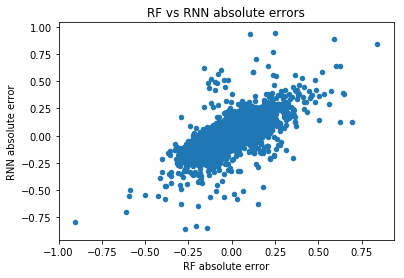

In [268]:
import matplotlib.pyplot as plt

ax = BeauRFScores.plot.scatter(x='abs_error_rf',y='abs_error_rnn', title='RF vs RNN absolute errors')
ax.set_xlabel("RF absolute error")
ax.set_ylabel("RNN absolute error")

In [348]:

BeauRFScores.index = test_sa_y_class.index

Delta_preds = np.abs(BeauRFScores.RNN - BeauRFScores.prediction)
Delta_preds = pd.DataFrame(Delta_preds)
Delta_preds['essay'] = test_sa_x_class
Delta_preds['RNN'] = BeauRFScores.RNN
Delta_preds['RF'] = BeauRFScores.prediction
Delta_preds['actual'] = test_sa_y_class.adjusted_domain1_score
Delta_preds['essay_set'] = BeauRFScores.essay_set
Delta_preds.columns = ['disagreement','essay', 'RNN','RF', 'actual', 'essay_set']

#find the five essays most disagreed upon by the two predictors
Delta_preds.sort_values('disagreement',ascending=False).head(5)


,disagreement,essay,RNN,RF,actual,essay_set
6876,0.833719,This conclusion of the story provides a sense ...,0.936856,0.103137,1.0,4.0
6856,0.784623,I believe that the author concludes the story...,0.035024,0.819647,0.0,4.0
6601,0.780497,The author Minfong Ho concluded the story Win...,0.955620,0.175123,1.0,4.0
6918,0.703108,I think the author puts that paragraph in the ...,0.151589,0.854698,0.0,4.0
6729,0.691801,This story is all about overcoming hardships a...,0.939040,0.247239,0.0,4.0


In [351]:
Delta_preds['RNN_diff'] = np.abs(Delta_preds['RNN'] - Delta_preds['actual'])

In [352]:
for row in Delta_preds.sort_values('RNN_diff',ascending=False).head(5).iterrows():
    print("essay {0}, was predicted {1} by RNN, {2} by RF, answer was {3}, belonged to {4} ".format(row[0],
                                                                                   np.around(row[1]['RNN'],3),
                                                                                   np.around(row[1]['RF'],3),
                                                                                  np.around(row[1]['actual'], 3),
                                                                                            row[1]['essay_set']))
    print(row[1]['essay'])
    print("")

essay 6729, was predicted 0.939 by RNN, 0.247 by RF, answer was 0.0, belonged to 4.0 
This story is all about overcoming hardships and disappointments as well as accepting and adapting to the things life throws at people, so it is appropriate that the story is ended with a goal and a determined attitude. Throughout the atire reading, Saeng sought comfort in the things most familiar to her, such as flower and the taste of bitter melon. She was hurting and disappointed, and those things were the only things that gave her peace. It was those things that save her the courage she needed to retake her drivers test in the spring, so it seems fitting that she end the story with the mention of the hibiscus. The end paragraph also shows that Saeng is adapting well to her new country. She says, when they come back... in the spring, when the snow melts and the geese return... At first the sounds of geese were alien to her, but now she has accepted their honking as a normal sound. This implies t

In [355]:
for row in Delta_preds.sort_values('disagreement',ascending=False).head(5).iterrows():
    print("essay {0}, was predicted {1} by RNN, {2} by RF, answer was {3}, belonged to {4} ".format(row[0],
                                                                                   np.around(row[1]['RNN'],3),
                                                                                   np.around(row[1]['RF'],3),
                                                                                  np.around(row[1]['actual'], 3),
                                                                                            row[1]['essay_set']))
    print(row[1]['essay'])
    print("")

essay 6876, was predicted 0.937 by RNN, 0.103 by RF, answer was 1.0, belonged to 4.0 
This conclusion of the story provides a sense of hope for the future. The girl is upset that she failed the test but still has hope for what will happen next. In the story the narrator says, She lifted her head. This quote is showing that she is not going to quit and give up, but that she will try until she succeeds. The conclusion of the story leaves readers to wonder if she will try harder and pass the test for the second time. When she says, when the snow melts and the geese return, this shows us that she is like the geese because their both going back for a hand fought journey. Also, when she says, and this hibiscus budding she is saying when everything comes to life and is at its highest peak she will take the test because she will have the most confidence. The author concludes the story to show that there is hope for the future and that she is not going to give up. Although she is upset a

In [263]:
vals = []
for essaySetValue in np.unique(BeauRFScores.essay_set):
    temp_deepLin = BeauRFScores[BeauRFScores.essay_set == essaySetValue]
    vals.append(cohen_kappa_score(temp_deepLin.actual_unnorm, temp_deepLin.RF_unnorm.astype('category'), weights='quadratic'))
    
vals

[0.8143151173677936,
 0.6977489848749655,
 0.6107347902945732,
 0.696475303031962,
 0.7894096920671944,
 0.6397463345890132,
 0.7241604040254694,
 0.6731841907101861]

## Combined Models

In [318]:
from keras.layers import Concatenate
RNN_comb_best = Sequential()
RNN_comb_best.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],
                       input_length=max_len_class,trainable=False,name='embed'))
RNN_comb_best.add(LSTM(20, return_sequences=True,name='LSTM1'))
RNN_comb_best.add(LSTM(20, return_sequences=True,name='LSTM3'))
RNN_comb_best.add(LSTM(20,name='LSTM2'))

Manual_Features_comb = Sequential()
Manual_Features_comb.add(Dense(25,input_shape=(len(colList),),name='ManualFeatureConnected'))

mergedOut = Concatenate()([RNN_comb_best.output, Manual_Features_comb.output])
mergedOut = Dense(1, name='out_layer')(mergedOut)

rnn_combined_final = Model([RNN_comb_best.input, Manual_Features_comb.input], mergedOut)
rnn_combined_final.compile(optimizer='adagrad',loss='mse', metrics=['accuracy'])
rnn_combined_final.summary()


rnn_combined_final.fit([sequences_matrix_class, np.array(train_x_obj[colList].fillna(0))],train_sa_y_class.adjusted_domain1_score, batch_size = 100, epochs=35, validation_split=0.15)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embed_input (InputLayer)        (None, 588)          0                                            
__________________________________________________________________________________________________
embed (Embedding)               (None, 588, 300)     10930500    embed_input[0][0]                
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 588, 20)      25680       embed[0][0]                      
__________________________________________________________________________________________________
LSTM3 (LSTM)                    (None, 588, 20)      3280        LSTM1[0][0]                      
__________________________________________________________________________________________________
ManualFeat

In [324]:
from keras.layers import *

FF_comb = Sequential()
FF_comb.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],
                       input_length=max_len_class,trainable=False,name='embed'))
FF_comb.add(Dense(100,name='deep1'))
FF_comb.add(Dense(50,name='deep2'))
FF_comb.add(Flatten())

Manual_Features_comb_ff = Sequential()
Manual_Features_comb_ff.add(Dense(25,input_shape=(len(colList),),name='ManualFeatureConnected'))

mergedOut_ff = Concatenate()([FF_comb.output, Manual_Features_comb_ff.output])
mergedOut_ff = Dropout(0.2)(mergedOut_ff)
mergedOut_ff = Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),activation='sigmoid',name='out_layer')(mergedOut_ff)


ff_combined_final = Model([FF_comb.input, Manual_Features_comb_ff.input], mergedOut_ff)
ff_combined_final.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
ff_combined_final.summary()

#final_model.summary()
#sahil_model_comb.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
ff_combined_final.fit([sequences_matrix_class, np.array(train_x_obj[colList].fillna(0))],np.asarray(pd.get_dummies(train_sa_y_class.adjusted_domain1_score)), batch_size = 150, epochs=35, validation_split=0.15)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embed_input (InputLayer)        (None, 588)          0                                            
__________________________________________________________________________________________________
embed (Embedding)               (None, 588, 300)     10930500    embed_input[0][0]                
__________________________________________________________________________________________________
deep1 (Dense)                   (None, 588, 100)     30100       embed[0][0]                      
__________________________________________________________________________________________________
deep2 (Dense)                   (None, 588, 50)      5050        deep1[0][0]                      
__________________________________________________________________________________________________
ManualFeat

In [320]:
from keras.layers import *

CNN_comb = Sequential()
CNN_comb.add(Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],
                       input_length=max_len_class,trainable=False,name='embed'))
CNN_comb.add(Conv1D(64, 5, activation = 'relu'))
CNN_comb.add(MaxPooling1D(2))
CNN_comb.add(Conv1D(64, 5, activation = 'relu'))
CNN_comb.add(MaxPooling1D(2))
CNN_comb.add(Flatten())

Manual_Features_comb_cnn = Sequential()
Manual_Features_comb_cnn.add(Dense(25,input_shape=(len(colList),),name='ManualFeatureConnected'))

mergedOut_cnn = Concatenate()([CNN_comb.output, Manual_Features_comb_cnn.output])
mergedOut_cnn = Dense(1, name='out_layer')(mergedOut_cnn)

cnn_combined_final = Model([CNN_comb.input, Manual_Features_comb_cnn.input], mergedOut_cnn)
cnn_combined_final.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
cnn_combined_final.summary()

#final_model.summary()
#sahil_model_comb.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
cnn_combined_final.fit([sequences_matrix_class, np.array(train_x_obj[colList].fillna(0))],train_sa_y_class.adjusted_domain1_score, batch_size = 100, epochs=35, validation_split=0.15)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embed_input (InputLayer)        (None, 588)          0                                            
__________________________________________________________________________________________________
embed (Embedding)               (None, 588, 300)     10930500    embed_input[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 584, 64)      96064       embed[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_22 (MaxPooling1D) (None, 292, 64)      0           conv1d_22[0][0]                  
__________________________________________________________________________________________________
conv1d_23 

In [325]:
rnn_comb_preds = rnn_combined_final.predict([sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class), np.asarray(test_x_obj[colList].fillna(0)).reshape(sequences_test_matrix_class.shape[0],len(colList))])
cnn_comb_preds = cnn_combined_final.predict([sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class), np.asarray(test_x_obj[colList].fillna(0)).reshape(sequences_test_matrix_class.shape[0],len(colList))])
ff_comb_preds = ff_combined_final.predict([sequences_test_matrix_class.reshape(sequences_test_matrix_class.shape[0],max_len_class), np.asarray(test_x_obj[colList].fillna(0)).reshape(sequences_test_matrix_class.shape[0],len(colList))])

ff_comb_preds = np.argmax(ff_comb_preds,axis=1)

comb_pred_frame = pd.DataFrame({'RNN':rnn_comb_preds.flatten(),
                           'CNN':cnn_comb_preds.flatten(),
                           'FF':ff_comb_preds.flatten(),
                           'actual':np.asarray(test_sa_y_class.adjusted_domain1_score),
                            'dataset': np.asarray(test_sa_y_class.essay_set)})
comb_pred_frame = comb_pred_frame.merge(DivSeries, on='dataset')

comb_pred_frame.FF = comb_pred_frame.FF.apply(RetrieveNormalize)

for colName in ['CNN', 'RNN', 'FF', 'actual']:
    comb_pred_frame[colName] = comb_pred_frame[colName] * comb_pred_frame['div']
    comb_pred_frame[colName] = comb_pred_frame[colName].apply(round)

comb_pred_frame.actual = comb_pred_frame.actual.astype(int)

In [326]:
QuadKappaCalculation = pd.DataFrame(columns = ['CNN', 'RNN', 'FF'],index = np.unique(comb_pred_frame.dataset))
for essaySetValue in np.unique(comb_pred_frame.dataset):
    temp_comb_ES = comb_pred_frame[comb_pred_frame.dataset == essaySetValue]
    QuadKappaCalculation.loc[essaySetValue, 'FF'] = cohen_kappa_score(temp_comb_ES.actual, temp_comb_ES.FF.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'RNN'] = cohen_kappa_score(temp_comb_ES.actual, temp_comb_ES.RNN.apply(round),weights='quadratic')
    QuadKappaCalculation.loc[essaySetValue, 'CNN'] = cohen_kappa_score(temp_comb_ES.actual, temp_comb_ES.CNN.apply(round),weights='quadratic')
QuadKappaCalculation.mean()

CNN    0.281917
RNN    0.051349
FF     0.555492
dtype: float64

In [327]:
print("FF combined RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(comb_pred_frame.actual, comb_pred_frame.FF.apply(round))),
                                       cohen_kappa_score(comb_pred_frame.actual, comb_pred_frame.FF.apply(round)),
                                        cohen_kappa_score(comb_pred_frame.actual, comb_pred_frame.FF.apply(round),weights='quadratic'),
                                                 accuracy_score(comb_pred_frame.actual, comb_pred_frame.FF.apply(round))))


print("CNN combined RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(comb_pred_frame.actual, comb_pred_frame.CNN.apply(round))),
                                       cohen_kappa_score(comb_pred_frame.actual, comb_pred_frame.CNN.apply(round)),
                                        cohen_kappa_score(comb_pred_frame.actual, comb_pred_frame.CNN.apply(round),weights='quadratic'),
                                                 accuracy_score(comb_pred_frame.actual, comb_pred_frame.CNN.apply(round))))

print("RNN combined RMSE, Cohen, Quad Cohen, accuracy: {0}, {1}, {2}, {3}".format(sqrt(mean_squared_error(comb_pred_frame.actual, comb_pred_frame.RNN.apply(round))),
                                       cohen_kappa_score(comb_pred_frame.actual, comb_pred_frame.RNN.apply(round)),
                                        cohen_kappa_score(comb_pred_frame.actual, comb_pred_frame.RNN.apply(round),weights='quadratic'),             
                                      accuracy_score(comb_pred_frame.actual, comb_pred_frame.RNN.apply(round))))


FF combined RMSE, Cohen, Quad Cohen, accuracy: 2.4478379504659085, 0.4099417112628072, 0.9641473609548521, 0.4842064714946071
CNN combined RMSE, Cohen, Quad Cohen, accuracy: 7.362033533636288, 0.212759991018314, 0.5446092514531857, 0.31432973805855163
RNN combined RMSE, Cohen, Quad Cohen, accuracy: 24.57694436143025, 0.02990794079049064, 0.2996733395574569, 0.08936825885978428
